# Group 6 - Week 4 - Assignment D

In [13]:
# Activate cell to enable module imports if not running notebook within Docker
# Enter command mode by pressing Esc key, then press Y key to re-enable this cell
# To disable this cell, enter command mode and press R key

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
import joblib
import math
import numpy as np
import pandas as pd
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split

from src.data import getAbsolute, resampling, explore_dataset as ex
from src.features import kpw_build_features, standardization, clustering, data_features
from src.models import cross_validation, save_predictions, blending, eval_model, eval_baseline

import xgboost as xgb

ModuleNotFoundError: No module named 'hyperopt'

In [3]:
ex.explore("train.csv")

=== dataframe info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-nul

In [4]:
ex.explore("test.csv")

=== dataframe info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id_old   3799 non-null   int64  
 1   Id       3799 non-null   int64  
 2   GP       3799 non-null   int64  
 3   MIN      3799 non-null   float64
 4   PTS      3799 non-null   float64
 5   FGM      3799 non-null   float64
 6   FGA      3799 non-null   float64
 7   FG%      3799 non-null   float64
 8   3P Made  3799 non-null   float64
 9   3PA      3799 non-null   float64
 10  3P%      3799 non-null   float64
 11  FTM      3799 non-null   float64
 12  FTA      3799 non-null   float64
 13  FT%      3799 non-null   float64
 14  OREB     3799 non-null   float64
 15  DREB     3799 non-null   float64
 16  REB      3799 non-null   float64
 17  AST      3799 non-null   float64
 18  STL      3799 non-null   float64
 19  BLK      3799 non-null   float64
 20  TOV      3799 non-null   floa

## Data Preparation

Convert to absolute value

In [5]:
df_train_abs = getAbsolute.abs(pd.read_csv("../data/raw/train.csv"),'train')
df_test_abs = getAbsolute.abs(pd.read_csv("../data/raw/test.csv"),'test')

## Feature Engineering - Clustering
- Drop ID column
- Binned_GP: 5 bins
- BadStats: Stats in lower 25% marked as 1, otherwise 0, and then get the average across multiple stats to form this new feature
- new_pct: Replace % column data with own recalculations
- add_POS: Add Possessions
- add_PPP: Add Points per Possessions
- add_3PP: Add 3-pointers per 100 Possessions
- add_FGP: Add Field Goals per 100 Possessions
- add_FTG: Add Free Throws per Games
- add_3PR: Add 3-Pointer % > 75% of mean
- add_FGR: Add Field Goal % > 75% of mean
- add_FTR: Add Free Throw % > 75% of mean
- add_RONM: Add RON per 100 Minutes
- add_RONP: Add RON per Possessions


In [6]:
df_train_clean = kpw_build_features.build(df_train_abs)
df_test_clean = kpw_build_features.build(df_test_abs)

y = df_train_clean.pop('TARGET_5Yrs')
X = df_train_clean.iloc[:,2:] 
X_test = df_test_clean.iloc[:,2:]
columns = X.columns

In [7]:
features = {
    'new_neg': False, # Impute negative values
    'new_upsample': False, # Upsample with smote
    'new_downsample': False, # Downsample randomly
    'new_pct': True, # Replace % column data with own recalculations
    'add_POS': True, # Add Possessions
    'add_PPP': True, # Add Points per Possessions
    'add_3PP': True, # Add 3-pointers per 100 Possessions
    'add_FGP': True, # Add Field Goals per 100 Possessions
    'add_FTG': True, # Add Free Throws per Games
    'add_3PR': True, # Add 3-Pointer % > 75% of mean
    'add_FGR': True, # Add Field Goal % > 75% of mean
    'add_FTR': True, # Add Free Throw % > 75% of mean
    'add_RONM': True, # Add RON per 100 Minutes
    'add_RONP': True, # Add RON per Possessions
    'rem_PTS': False, # Remove Points per Game
    'rem_pct': False # Remove 3P%, FP% and FT%
}

X, y = data_features.engineer(X, y, features)
X_test, _ = data_features.engineer(X_test, None, features)

## Standardization

In [8]:
sc,X_std,X_test_std = standardization.standardScale(X,X_test)

## Create training and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_std,y,test_size=0.2, random_state=8, stratify=y)

## Baseline performance

Accuracy Score:  0.833625  F1 Score  0.9092644352034903  Precision Score  0.833625  Recall Score  1.0 (BASELINE)


0.5

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


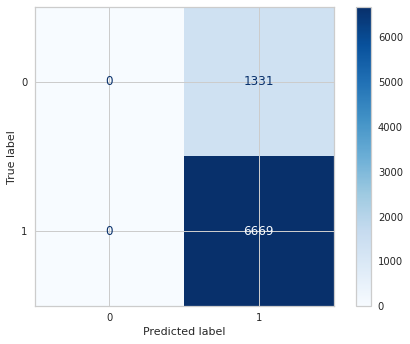

In [10]:
eval_baseline.eval_baseline(X_std, y)
roc_auc_score(y,np.ones(len(X_std)))

Although the F1 score and Accuracy score is pretty high, the confusion metric and AUROC (0.5) shows that the baseline model cannot identify negative cases.

## Model Selection

There are different positions in a basketball team, and each position can have its own strength. Good players can be capable in multiple positions. Therefore, a player with good performance across the board, or a player specialising in some areas can be considered as a good player. Determining if a player will stay in the League after 5 years or not, can be a linear problem and can also be a nonlinear problem. 

We selected LogisticRegression and XGBClassifier for this experiment.

In this section, we use cross_val_score and hyperopt to select model

In [11]:
log_reg_space = {
    'C' : hp.quniform('C', 0.01, 1, 0.01),
    'l1_ratio': hp.quniform('l1_ratio', 0.1, 0.9, 0.05)
}

def tune_log_reg(space):
    log_reg_hyperopt = LogisticRegression(
        penalty = 'elasticnet',
        C = space['C'],
        solver = 'saga',
        max_iter = 200,
        n_jobs = -1,
        l1_ratio = space['l1_ratio']
    )
    scores = cross_val_score(log_reg_hyperopt, X_std, y, scoring="roc_auc", cv=10)
    return {"loss": 1-scores.mean(), "status": STATUS_OK}

log_reg_best = fmin(
    fn = tune_log_reg,
    space = log_reg_space,
    algo = tpe.suggest,
    max_evals = 10
)

100%|██████████| 10/10 [02:12<00:00, 13.21s/trial, best loss: 0.29728154266931617]


In [12]:
log_reg_best

{'C': 0.13, 'l1_ratio': 0.5}

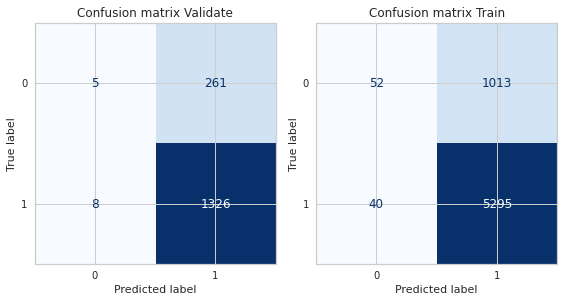

LogisticRegression(C=0.08, l1_ratio=0.2, max_iter=200, n_jobs=-1,
                   penalty='elasticnet', solver='saga')


(LogisticRegression(C=0.08, l1_ratio=0.2, max_iter=200, n_jobs=-1,
                    penalty='elasticnet', solver='saga'),
 0.7005852924482225,
 0.6958748069574235)

In [13]:
eval_model.eval_model(LogisticRegression(
        penalty = 'elasticnet',
        C = 0.13,
        solver = 'saga',
        max_iter = 200,
        n_jobs = -1,
        l1_ratio = 0.5
    ), X_train, y_train, X_val, y_val)

In [14]:
X_array = np.asarray(X_std)
y_array = np.asarray(y)

In [15]:
xgb_space = {
    'max_depth' : hp.quniform('max_depth', 1.0, 5.0, 1.0),
    'learning_rate' : hp.quniform('learning_rate', 0.001, 0.1, 0.001),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 3, 0.05)
}

def tune_xgb(space):
    xgb_hyperopt = xgb.XGBClassifier(
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'], 
        objective='binary:logistic', 
        scale_pos_weight=space['scale_pos_weight'],
        verbosity = 0
    )
    scores = cross_val_score(xgb_hyperopt, X_array, y_array, scoring="roc_auc", cv=5)
    return {"loss": 1-scores.mean(), "status": STATUS_OK}

xgb_best = fmin(
    fn = tune_xgb,
    space = xgb_space,
    algo = tpe.suggest,
    max_evals = 10
)

[02:20:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [16]:
xgb_best

{'learning_rate': 0.053, 'max_depth': 2.0, 'scale_pos_weight': 1.25}

[02:22:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

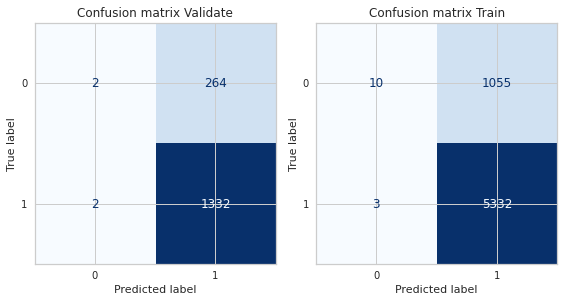

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.053, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.25, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.053, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1.25, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 0.7004092911106125,
 0.6714485802211676)

In [18]:
eval_model.eval_model(xgb.XGBClassifier(
        max_depth=2,
        learning_rate=0.053, 
        objective='binary:logistic', 
        scale_pos_weight=1.25
    ), X_train, y_train, X_val, y_val)

### Observation
Both trained LogisticRegression and XGBoost models have about the same performance (AUROC ~ 0.7) in the ability of identifying positive and negative cases, which are better than baseline (AUROC = 0.5), and still have plenty of room to improve.

When looking closer into confusion metric, FP and FN observations, we can see that negative cases are difficult to be separated from positive cases. Some negative observations are very close to positive observations in all features, and yet have the opposite TARGET values. All feature engineering we have tried didn’t offer noticeable improvement. Based on all these factors, we have concluded that there is a performance ceiling this dataset has. In order to improve the performance of our predicting model, we will require new meaningful features.

A player stay in the League or not can have factors including and not limited to
- Performance (Player stats, which we have some)
- Popularity/Fame
- Injuries (Physical or Mental)
- Career Transition (Becoming movie stars, switching sports ... etc)
- Scandals (crime, doping ... etc)

**As a result, with the information we’ve gathered so far, the performance of our models cannot surpass AUROC 0.7 in general.**


## Model Training

In [20]:
clf = LogisticRegression(
        penalty = 'elasticnet',
        C = 0.13,
        solver = 'saga',
        max_iter = 200,
        n_jobs = -1,
        l1_ratio = 0.5
    )
clf.fit(X_std, y)
joblib.dump(clf,"../models/group6_week4_model")

['../models/group6_week4_model']

## Generate Prediction and Save the CSV

In [23]:
filename = 'group6_week4.csv'
save_predictions.save_predictions(f'{filename}', clf, X_test)

Predictions saved to ../data/predictions/group6_week4.csv


array([[0.00000000e+000, 6.09592547e-100],
       [1.00000000e+000, 0.00000000e+000],
       [2.00000000e+000, 4.23904157e-145],
       ...,
       [3.79600000e+003, 8.63214828e-017],
       [3.79700000e+003, 2.66281970e-187],
       [3.79800000e+003, 5.04923494e-068]])